# Cas Kaggle

**Nerea de La Torre Veguillas 1669013**

**Helena Boneu Vidal 1673129**

Hem utilitzat el dataset **Harry Potter Dataset**.

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as bplt
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, r2_score, confusion_matrix, average_precision_score, precision_recall_curve, auc, roc_curve,roc_auc_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
import re
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

Carreguem el **dataset**:

En un principi, quan vam observar el datset per primer cop, vam veure que hi havien bastantes característiques dels personatges que no hi eren, per això vam decidir fer una cerca a internet i buscar la informació faltant. Tot i així, no vam poder aconseguir trobar totes les dades necessàries, però ens va ajudar a obtenir un dataset més complert per utilitzar en la nostra predicció.

In [239]:
df = 'C:/Users/nerea/OneDrive/Escritorio/cosas uni/3r/AP/kaggle/data/harry-potter-dataset/Characters.csv' #'C:/Users/helen/OneDrive/Documentos/3r Carrera/1r semestre/Aprenentatge Computacional/Kaggle/data/harry-potter-dataset/Characters.csv'

df = pd.read_csv(df, delimiter=';')
df.head(5)

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Birth,Death
0,1,Harry James Potter,Male,Student,Gryffindor,"11"" Holly phoenix feather",Stag,Human,Half-blood,Black,Bright green,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,31 July 1980,NaN
1,2,Ronald Bilius Weasley,Male,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,Human,Pure-blood,Red,Blue,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,1 March 1980,NaN
2,3,Hermione Jean Granger,Female,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,Human,Muggle-born,Brown,Brown,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,"19 September, 1979",NaN
3,4,Albus Percival Wulfric Brian Dumbledore,Male,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,Human,Half-blood,Silver,Blue,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,Late August 1881,"30 June, 1997"
4,5,Rubeus Hagrid,Male,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,Half-Human/Half-Giant,Part-Human (Half-giant),Black,Black,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,6 December 1928,NaN


# 1. EDA i Preprocessing

A continuació, mirem si hi ha **NaNs** en el dataset.

In [240]:
print("Columnes amb NaNs:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)

nan_columns = df.columns[df.isna().sum()>0].tolist()
print('\nNúmero de NaNs per columna:\n')
print (df.loc[:,nan_columns].isna().sum())

Columnes amb NaNs:

Job              5.000000
House           16.428571
Patronus         5.000000
Blood status     5.000000
Hair colour      0.714286
Eye colour      12.142857
Skills           5.000000
Birth            9.285714
Death           70.000000
dtype: float64

Número de NaNs per columna:

Job              7
House           23
Patronus         7
Blood status     7
Hair colour      1
Eye colour      17
Skills           7
Birth           13
Death           98
dtype: int64


Com que volem fer la predicció de les cases dels personatges, no ens interessa tenir personatges que no tenen casa. Per aquesta raó, eliminem les files dels quals **no** tenen **casa**. A més, hi ha personatges que directament no poden tenir casa, ja que no pertanyen al món màgic.

In [241]:
df = df.dropna(subset=['House'])

També veiem que les característiques **Birth** i **Death** no són rellevants per a la nostra predicció. Per tant, les podem eliminar del nostre dataset.

In [242]:
df = df.drop(columns=['Birth', 'Death'])
df.keys()

Index(['Id', 'Name', 'Gender', 'Job', 'House', 'Wand', 'Patronus', 'Species',
       'Blood status', 'Hair colour', 'Eye colour', 'Loyalty', 'Skills'],
      dtype='object')

A continuació, mirem les **columnes** que tenen **NaNs**.

In [243]:
print("Columnes amb NaNs:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)

nan_columns = df.columns[df.isna().sum()>0].tolist()
print('\nNúmero de NaNs per columna:\n')
print (df.loc[:,nan_columns].isna().sum())

Columnes amb NaNs:

Job              4.273504
Patronus         5.128205
Blood status     2.564103
Eye colour      10.256410
Skills           5.128205
dtype: float64

Número de NaNs per columna:

Job              5
Patronus         6
Blood status     3
Eye colour      12
Skills           6
dtype: int64


Característica **Eye colour**:

Per omplir els NaNs d'aquesta característica farem servir l'algorisme **KNN**. Per aquesta raó, utilitzarem les característiques **Hair colour** i **Gender**, ja que són dues característiques importants per fer la predicció de **Eye colour**.

Per tant, primer haurem de fer **encoding** de les dos característiques, ja que són **variables categòriques**.

In [244]:
numeric_features = df.select_dtypes(np.number).keys()
non_numeric = ['Hair colour', 'Gender']
df.loc[:,non_numeric] = df.loc[:,non_numeric].apply(LabelEncoder().fit_transform)

A continuació, haurem de fer **encoding** de la característica **Eye colour**, ja que també l'utilitzarem en la predicció dels Nans. Però en aquest cas, com que tenim alguns Nans, el que farem és només convertir a númeric els valors que no ho són.

In [245]:
non_numeric = ['Eye colour']

# Només apliquem LabelEncoder a les files que no són NaN
for columna in non_numeric:
    # Filtrem les files no nules per aplicar el fit_transform
    non_nan_df = df[columna].dropna()  # Elimina els NaN
    
    df.loc[non_nan_df.index, columna] = LabelEncoder().fit_transform(non_nan_df)

Ara ja podem aplicar un **KNN** per trobar la característica **Eye colour** dels personatges que no la tenen.

In [246]:
imputer = KNNImputer(n_neighbors=5)
df['Eye colour'] = imputer.fit_transform(df[['Eye colour', 'Gender', 'Hair colour']])

df['Eye colour'] = df['Eye colour'].round().astype(int)  # Si el nombre és un float, l'arrodonim i el convertim a int

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills
0,1,Harry James Potter,1,Student,Gryffindor,"11"" Holly phoenix feather",Stag,Human,Half-blood,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...
1,2,Ronald Bilius Weasley,1,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,Human,Pure-blood,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping
2,3,Hermione Jean Granger,0,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,Human,Muggle-born,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything
3,4,Albus Percival Wulfric Brian Dumbledore,1,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,Human,Half-blood,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...
4,5,Rubeus Hagrid,1,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,Half-Human/Half-Giant,Part-Human (Half-giant),2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...


Característica **Species**:

En aquesta categoria, el primer que hem fet a sigut borrar els parèntesis explicatius que tenien alguns personatges que són **Human**, ja que només ens interesa saber directament la seva espècie.

In [247]:
# Eliminem si hi ha algun espai al final
df['Species'] = df['Species'].str.strip()

# Eliminem els parèntesis explicatius
df['Species'] = df['Species'].str.replace(r'\s*\(.*?\)', '', regex=True)

df['Species'].unique()

array(['Human', 'Half-Human/Half-Giant', 'Werewolf', 'Ghost'],
      dtype=object)

A més, com que **no** tenim **Nans** en aquesta característica, podem fer **encoding** de tots els seus valors.

In [248]:
numeric_features = df.select_dtypes(np.number).keys()
non_numeric = ['Species']
df.loc[:,non_numeric] = df.loc[:,non_numeric].apply(LabelEncoder().fit_transform)
df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills
0,1,Harry James Potter,1,Student,Gryffindor,"11"" Holly phoenix feather",Stag,2,Half-blood,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...
1,2,Ronald Bilius Weasley,1,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,Pure-blood,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping
2,3,Hermione Jean Granger,0,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,Muggle-born,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything
3,4,Albus Percival Wulfric Brian Dumbledore,1,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,Half-blood,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...
4,5,Rubeus Hagrid,1,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,1,Part-Human (Half-giant),2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...


Característica **Blood status**:

A aquesta característica també apliquem un **KNN** per trobar els valors que ens falten.

En aquest cas, el procés serà igual al de la característica **Eye colour**. En primer lloc, transformarem només els valors no NaNs a valors numèrics i a continuació, ja podrem fer la predicció.

In [249]:
non_numeric = ['Blood status']

# Només apliquem LabelEncoder a les files que no són NaN
for columna in non_numeric:
    # Filtrarem les files no nules per aplicar el fit_transform
    non_nan_df = df[columna].dropna()  # Elimina els NaN
    
    df.loc[non_nan_df.index, columna] = LabelEncoder().fit_transform(non_nan_df)

Ara ja podem aplicar un **KNN** per trobar la característica **Blood status** dels personatges que no la tenen. En aquest cas, per fer la predicció utilitzarem la característica **Species** i també **Blood status**.

In [250]:
imputer = KNNImputer(n_neighbors=5)
df['Blood status'] = imputer.fit_transform(df[['Blood status', 'Species']])

df['Blood status'] = df['Blood status'].round().astype(int)  # Si el nombre és un float, l'arrodonim i el convertim a int

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills
0,1,Harry James Potter,1,Student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...
1,2,Ronald Bilius Weasley,1,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping
2,3,Hermione Jean Granger,0,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything
3,4,Albus Percival Wulfric Brian Dumbledore,1,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...
4,5,Rubeus Hagrid,1,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...


Característica **Job**:

Podem veure que hi ha **personatges** que tenen **més d'una feina**, per tant, el primer que farem serà **separar** les diferents feines en diverses **columnes**.

A més, mirarem primer quan és el màxim de feines que pot tenir un personatge. D'aquesta manera sabrem quantes columnes haurem de crear.

In [251]:
# Eliminem si hi ha algun espai al final
df['Job'] = df['Job'].str.strip()

# Eliminem si hi han parèntesis explicatius
df['Job'] = df['Job'].str.replace(r'\s*\(.*?\)', '', regex=True)

# Contem quantes feines té cada personatge, sabent que cada feina està separada per '|' i ignorant els NaNs
df['Job_Count'] = df['Job'].apply(lambda x: len(x.split('|')) if pd.notna(x) else 0)

# Filtrem les files que tenen més d'una feina
multiple_jobs = df[df['Job_Count'] > 1]

print("Personatges amb més d'una feina:")
print(multiple_jobs[['Name', 'Job', 'Job_Count']])

print("\nEl màxim de feines que te algún dels personatges és de",max(multiple_jobs['Job_Count']),".")

Personatges amb més d'una feina:
                      Name                                                Job  \
4            Rubeus Hagrid  Keeper of Keys and Grounds | Professor of Care...   
16  Percy Ignatius Weasley  Student|Prefect|  Personal assistant to Barty ...   
29      Minerva McGonagall  Professor of Transfiguration | Head of Gryffindor   
36         Filius Flitwick            Professor of Charms | Head of Ravenclaw   
45           Severus Snape           Professor of Potions | Head of Slytherin   
50   Dolores Jane Umbridge  Professor of Defence Against the Dark Arts | D...   
81           Pomona Sprout  Professor of Herbology | Head of Hufflepuff House   
94    Kingsley Shacklebolt                        Auror  | Minister for Magic   
98        Rufus Scrimgeour           Head of Auror Office| Minister for Magic   

    Job_Count  
4           2  
16          3  
29          2  
36          2  
45          2  
50          2  
81          2  
94          2  
98          

Com que hem vist que el **màxim** de **feines** és de **3**, crearem **3 columnes** addicionals separant les feines de cada personatge. Les columnes que crearem seran:

* **Job_1** (per la 1ra feina)
* **Job_2** (per la 2na feina)
* **Job_3** (per la 3ra feina)

In [252]:
# Separem les feines en 3 columnes
feines_separades = df['Job'].apply(lambda x: x.split('|') if pd.notna(x) else []).apply(pd.Series)

# Canviem el nom de les columnes
feines_separades.columns = [f'Job_{i+1}' for i in range(feines_separades.shape[1])]

# Afegim les columnes al df
df = pd.concat([df, feines_separades], axis=1)

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Job_Count,Job_1,Job_2,Job_3
0,1,Harry James Potter,1,Student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,1,Student,NaN,NaN
1,2,Ronald Bilius Weasley,1,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,1,Student,NaN,NaN
2,3,Hermione Jean Granger,0,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,1,Student,NaN,NaN
3,4,Albus Percival Wulfric Brian Dumbledore,1,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,1,Headmaster,NaN,NaN
4,5,Rubeus Hagrid,1,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,2,Keeper of Keys and Grounds,Professor of Care of Magical Creatures,NaN


A continuació, **agruparem** les feines de cada personatge en feines més globals. A més, els personatges que tinguin més d'una feina, triarem per a aquests la que és repeteix més vegades d'entre els personatges que només en tenen una.

In [253]:
# Creem un diccionari per agrupar feines similars
feines_similars = {
    'Professor': ['Professor', 'Defence Against the Dark Arts'],
    'House Ghost': ['House Ghost'],
    'Founder': ['Founder'],
    'School Head' : ['Headmaster', 'Headmistress'],
    'Gringotts' : ['Gringotts'],
    'Hogwarts service' : ['Matron', 'Flying Instructor', 'Astronomer', 'keeper of keys'],
    'Magical Government' : ['Magical', 'Muggle Artefacts'],
    'Death eater' : ['unspeakable', 'voldemort', 'executioner'],
    'Barman' : ['barman'],   
    'Quidditch' : ['quidditch'],
    'Head of House' : ['head'],
    'Personal Assistant' : ['Personal assistant']              
}

def agrupar_feina(feina):
    # Ens assegurem que les paraules estiguin en minúscules i sense espais addicionals
    feina = feina.strip().lower()
    
    for categoria, similares in feines_similars.items():
        # Comparem la feina amb les paraules de la llista
        llista = [item.strip().lower() for item in similares]
        paraules_dividides = []
        for paraula in llista:
            paraula_separada = paraula.split(' ')
            paraules_dividides.append(' '.join(paraula_separada))
        for i in paraules_dividides:
             if i in feina:
                return categoria.lower()
    return feina

# Filtrem els personatges que tenen 1, 2 o 3 feines
df_job_1 = df[df['Job_Count'] == 1]
df_job_2 = df[df['Job_Count'] == 2]
df_job_3 = df[df['Job_Count'] == 3]

# Ens guardem també els personatges que no tenen cap feina
df_sense_job = df[df['Job_Count'] == 0]

# Apliquem la funció per agrupar les feines més similars de la columna Job_1
df_job_1['Job_1_Agrupat'] = df_job_1['Job_1'].apply(agrupar_feina)

# Apliquem la funció per agrupar les feines més similars de la columna Job_2
df_job_2['Job_1_Agrupat'] = df_job_2['Job_1'].apply(agrupar_feina)
df_job_2['Job_2_Agrupat'] = df_job_2['Job_2'].apply(agrupar_feina)

# Apliquem la funció per agrupar les feines més similars de la columna Job_3
df_job_3['Job_1_Agrupat'] = df_job_3['Job_1'].apply(agrupar_feina)
df_job_3['Job_2_Agrupat'] = df_job_3['Job_2'].apply(agrupar_feina)
df_job_3['Job_3_Agrupat'] = df_job_3['Job_3'].apply(agrupar_feina)

# Contem quantes vegades és repeteixen les feines de la columna Job_1
feines_repetides_job_1 = df_job_1['Job_1_Agrupat'].value_counts()

print("Feines repetides Job_1:\n")
print(feines_repetides_job_1)

# Concatenem tots els datasets
df_tot = pd.concat([df_sense_job, df_job_1, df_job_2, df_job_3], ignore_index=True, sort=False)

# Ordenem el dataset respecte la característica Id
df_tot = df_tot.sort_values(by='Id')

df_tot.head()

Feines repetides Job_1:

Job_1_Agrupat
student               53
professor              9
auror                  7
death eater            7
house ghost            4
founder                4
magical government     4
hogwarts service       3
housewife              2
school head            2
gringotts              2
wandmaker              1
school governor        1
dragonologist          1
minister for magic     1
barman                 1
quidditch              1
Name: count, dtype: int64


C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\534045962.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_job_1['Job_1_Agrupat'] = df_job_1['Job_1'].apply(agrupar_feina)
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\534045962.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_job_2['Job_1_Agrupat'] = df_job_2['Job_1'].apply(agrupar_feina)
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\534045962.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Job_Count,Job_1,Job_2,Job_3,Job_1_Agrupat,Job_2_Agrupat,Job_3_Agrupat
5,1,Harry James Potter,1,Student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,1,Student,NaN,NaN,student,NaN,NaN
6,2,Ronald Bilius Weasley,1,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,1,Student,NaN,NaN,student,NaN,NaN
7,3,Hermione Jean Granger,0,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,1,Student,NaN,NaN,student,NaN,NaN
8,4,Albus Percival Wulfric Brian Dumbledore,1,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,1,Headmaster,NaN,NaN,school head,NaN,NaN
108,5,Rubeus Hagrid,1,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,2,Keeper of Keys and Grounds,Professor of Care of Magical Creatures,NaN,hogwarts service,professor,NaN


Respecte als **personatges** que tenen **més d'una feina**, mirarem quina d'aquestes està més **repetida** en els que només en tenen una i li assignarem aquesta.

In [254]:
# Creem un diccionari amb els valors de repetició de cada Job_1
dict = df_job_1['Job_1_Agrupat'].value_counts().to_dict()

# Funció per assignar la feina que és repeteix més vegades
def feina_frequent(fila):
    jobs = [fila['Job_1_Agrupat'], fila.get('Job_2_Agrupat'), fila.get('Job_3_Agrupat')]
    jobs = [job for job in jobs if job]
    feina_mes_frequent = max(jobs, key=lambda job: dict.get(job, 0))
    return feina_mes_frequent

# Assignem la feina als personatges que només en tenen 1
df_job_1['Job_Final'] = df_job_1['Job_1_Agrupat']

# Assignem la feina més freqüent als personatges amb 2 o 3 feines
df_job_2['Job_Final'] = df_job_2.apply(feina_frequent, axis=1)
df_job_3['Job_Final'] = df_job_3.apply(feina_frequent, axis=1)

# Concatenem tots els datasets (afegim també els personatges que no tenen cap feina)
df_tot = pd.concat([df_sense_job, df_job_1, df_job_2, df_job_3], ignore_index=True, sort=False)

# Ordenem el dataset respecte la característica Id
df_tot = df_tot.sort_values(by='Id')

# Assignem els valors de Job_Final a Job
df_tot['Job'] = df_tot['Job_Final']

# Eliminem les columnes que ja no necessitem
df = df_tot.drop(columns=['Job_1', 'Job_2', 'Job_3', 'Job_1_Agrupat', 'Job_2_Agrupat', 'Job_3_Agrupat', 'Job_Final', 'Job_Count'])

df.head()

C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\2882465331.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_job_1['Job_Final'] = df_job_1['Job_1_Agrupat']
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\2882465331.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_job_2['Job_Final'] = df_job_2.apply(feina_frequent, axis=1)
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\2882465331.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills
5,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...
6,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping
7,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything
8,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...
108,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...


Característica **Skills**:

En aquest cas, farem servir el mateix procediment que hem utilitzat en la característica **Job**.

In [255]:
# Eliminem si hi ha algun espai al final
df['Skills'] = df['Skills'].str.strip()

# Eliminem si hi ha parèntesis explicatius
df['Skills'] = df['Skills'].str.replace(r'\s*\(.*?\)', '', regex=True)

# Contem quantes skills té cada personatge, sabent que cada skill està separada per '|' o ',' i ignorant els NaNs
df['Skills_Count'] = df['Skills'].apply(
    lambda x: len(x.split('|')) if isinstance(x, str) and '|' in x else 
            (len(x.split(',')) if isinstance(x, str) and ',' in x else 
            1 if isinstance(x, str) else 0)
)

# Filtrem les files que tenen més d'una skill
multiple_jobs = df[df['Skills_Count'] > 1]

print("Personatges amb més d'una feina:")
print(multiple_jobs[['Name', 'Skills', 'Skills_Count']])

print("\nEl màxim de Skills que te algún dels personatges és de",max(multiple_jobs['Skills_Count']))

Personatges amb més d'una feina:
                               Name  \
5                Harry James Potter   
6             Ronald Bilius Weasley   
108                   Rubeus Hagrid   
12    Ginevra (Ginny) Molly Weasley   
16                     James Potter   
17                     Sirius Black   
116          Percy Ignatius Weasley   
20    (Bill) William Arthur Weasley   
21                  Charles Weasley   
22                      Lee Jordan    
23                      Oliver Wood   
32                    Molly Weasley   
34                Quirinus Quirrell   
44                       Terry Boot   
46                     Draco Malfoy   
50   Horace Eugene Flaccus Slughorn   
56               Tom Marvolo Riddle   
60                  Graham Montague   
62                     Marcus Flint   
64                     Roger Davies   
68                 Rowena Ravenclaw   
76                 Nymphadora Tonks   
77                 Newton Scamander   
82                 Ernest Macmi

Com que hem vist que el **màxim** de **skills** és de **6**, crearem **6 columnes** addicionals separant les skills de cada personatge. Les columnes que crearem seran:

* **Skill_1** (per la 1ra skill)
* **Skill_2** (per la 2na skill)
* **Skill_3** (per la 3ra skill)
* **Skill_4** (per la 4ta skill)
* **Skill_5** (per la 5ena skill)
* **Skill_6** (per la 6ena skill)

In [256]:
# Dividim les skills en 6 columnes
skills_separades = df['Skills'].apply(
    lambda x: re.split(r'[|,]', x) if pd.notna(x) else []
).apply(pd.Series)

# Canviem el nom de les columnes
skills_separades.columns = [f'Skill_{i+1}' for i in range(skills_separades.shape[1])]

# Afegim les columnes al df
df = pd.concat([df, skills_separades], axis=1)

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Skills_Count,Skill_1,Skill_2,Skill_3,Skill_4,Skill_5,Skill_6
5,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,4,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,3,Parseltongue,Defence Against the Dark Arts,Seeker,NaN,NaN,NaN
6,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,1,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,2,Wizard chess,Quidditch goalkeeping,NaN,NaN,NaN,NaN
7,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,5,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,1,Almost everything,NaN,NaN,NaN,NaN,NaN
8,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,1,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,1,Considered by many to be one of the most power...,NaN,NaN,NaN,NaN,NaN
108,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,0,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,3,Resistant to stunning spells,above average strength,crossbowmanship,NaN,NaN,NaN


A continuació, **agruparem** les skills de cada personatge en skills més globals. A més, els personatges que tinguin més d'una skill, triarem per a aquests la que és repeteix més vegades d'entre els personatges que només en tenen una.

In [257]:
# Creem un diccionari per agrupar skills similars
skills_similars = {
    'prefect': ['prefect', 'head boy'],
    'Duel': ['skilled duellist', 'duelling', 'duellist', 'combat'],
    'divination': ['divination', 'seer'],
    'Charms': ['charms', 'hex', 'spells', 'transfiguration', 'defensive magic', 'occlumens'],
    'Mail': ['propaganda'],
    'Heal': ['curing', 'medical', 'healing'],
    'Potions': ['potioneer', 'potions'],
    'auror': ['auror'],
    'magical creatures': ['magical creatures', 'giants','nargles', 'Magizoology'],
    'parsel': ['parsel', 'parselmouths'],
    'great wizard': ['powerful', 'great wizard'],
    'dark arts': ['curse', 'dark', 'voldemort', 'punishment', 'betraying', 'undercover', 'manipulation', 'heir of slytherin', 'inferi'],
    'veela': ['veela'],
    'wand': ['wandcraft'],
    'Quidditch' : ['chaser', 'seeker', 'beater', 'keeper', 'quidditch', 'captain', 'flying'],
    'wisdom': ['wisdom', 'revising'],
    'perfect': ['model student', 'everything'],
    'skilled': ['skilled'],
    'intelligent': ['intelligence', 'intelligent'],
    'dancer': ['dancer'],
    'no skills': ['less', 'above average'],
    'professor': ['teaching', 'professor'],
    'other' : ['peeves', 'love potion', 'caring'],
    'order': ['order']    
}

def agrupar_skill(skill):
    # Ens assegurem que les paraules estiguin en minúscules i sense espais addicionals
    skill = skill.strip().lower()
    
    for categoria, similares in skills_similars.items():
        # Comparem la skill amb les paraules de la llista
        llista = [item.strip().lower() for item in similares]
        paraules_dividides = []
        for paraula in llista:
            paraula_separada = paraula.split(' ')
            paraules_dividides.append(' '.join(paraula_separada))
        for i in paraules_dividides:
            if i in skill:
                return categoria.lower()
    return skill

# Filtrem els personatges que tenen 1, 2, 3, 4, 5 o 6 skills
df_skill_1 = df[df['Skills_Count'] == 1]
df_skill_2 = df[df['Skills_Count'] == 2]
df_skill_3 = df[df['Skills_Count'] == 3]
df_skill_4 = df[df['Skills_Count'] == 4]
df_skill_5 = df[df['Skills_Count'] == 5]
df_skill_6 = df[df['Skills_Count'] == 6]

# Ens guardem també els personatges que no tenen cap skill
df_sense_skill = df[df['Skills_Count'] == 0]

# Apliquem la funció per agrupar les skills més similars de la columna Skill_1
df_skill_1['Skill_1_Agrupat'] = df_skill_1['Skill_1'].apply(agrupar_skill)

# Apliquem la funció per agrupar les skills més similars de la columna Skill_2
df_skill_2['Skill_1_Agrupat'] = df_skill_2['Skill_1'].apply(agrupar_skill)
df_skill_2['Skill_2_Agrupat'] = df_skill_2['Skill_2'].apply(agrupar_skill)

# Apliquem la funció per agrupar les skills més similars de la columna Skill_3
df_skill_3['Skill_1_Agrupat'] = df_skill_3['Skill_1'].apply(agrupar_skill)
df_skill_3['Skill_2_Agrupat'] = df_skill_3['Skill_2'].apply(agrupar_skill)
df_skill_3['Skill_3_Agrupat'] = df_skill_3['Skill_3'].apply(agrupar_skill)

# Apliquem la funció per agrupar les skills més similars de la columna Skill_4
df_skill_4['Skill_1_Agrupat'] = df_skill_4['Skill_1'].apply(agrupar_skill)
df_skill_4['Skill_2_Agrupat'] = df_skill_4['Skill_2'].apply(agrupar_skill)
df_skill_4['Skill_3_Agrupat'] = df_skill_4['Skill_3'].apply(agrupar_skill)
df_skill_4['Skill_4_Agrupat'] = df_skill_4['Skill_4'].apply(agrupar_skill)

# Apliquem la funció per agrupar les skills més similars de la columna Skill_5
df_skill_5['Skill_1_Agrupat'] = df_skill_5['Skill_1'].apply(agrupar_skill)
df_skill_5['Skill_2_Agrupat'] = df_skill_5['Skill_2'].apply(agrupar_skill)
df_skill_5['Skill_3_Agrupat'] = df_skill_5['Skill_3'].apply(agrupar_skill)
df_skill_5['Skill_4_Agrupat'] = df_skill_5['Skill_4'].apply(agrupar_skill)
df_skill_5['Skill_5_Agrupat'] = df_skill_5['Skill_5'].apply(agrupar_skill)

# Apliquem la funció per agrupar les skills més similars de la columna Skill_6
df_skill_6['Skill_1_Agrupat'] = df_skill_6['Skill_1'].apply(agrupar_skill)
df_skill_6['Skill_2_Agrupat'] = df_skill_6['Skill_2'].apply(agrupar_skill)
df_skill_6['Skill_3_Agrupat'] = df_skill_6['Skill_3'].apply(agrupar_skill)
df_skill_6['Skill_4_Agrupat'] = df_skill_6['Skill_4'].apply(agrupar_skill)
df_skill_6['Skill_5_Agrupat'] = df_skill_6['Skill_5'].apply(agrupar_skill)
df_skill_6['Skill_6_Agrupat'] = df_skill_6['Skill_6'].apply(agrupar_skill)

# Contem quantes vegades és repeteixen les skills de la columna Skill_1
skills_repetides_skill_1 = df_skill_1['Skill_1_Agrupat'].value_counts()

print("Skills repetides Skill_1:\n")
print(skills_repetides_skill_1)

# Concatenem tots els datasets
df_tot = pd.concat([df_sense_skill, df_skill_1, df_skill_2, df_skill_3, df_skill_4, df_skill_5, df_skill_6], ignore_index=True, sort=False)

# Ordenem el dataset respecte la característica Id
df_tot = df_tot.sort_values(by='Id')

df_tot.head(40)

Skills repetides Skill_1:

Skill_1_Agrupat
quidditch             16
duel                   9
charms                 8
dark arts              7
potions                5
magical creatures      4
prefect                4
auror                  4
herbology              3
divination             3
great wizard           2
other                  2
veela                  2
animagus               2
heal                   2
dancer                 1
mail                   1
metamorphmagus         1
perfect                1
parsel                 1
wand                   1
muggle world works     1
photography            1
pyrotechnics           1
astronomy              1
Name: count, dtype: int64


C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\3255000754.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skill_1['Skill_1_Agrupat'] = df_skill_1['Skill_1'].apply(agrupar_skill)
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\3255000754.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_skill_2['Skill_1_Agrupat'] = df_skill_2['Skill_1'].apply(agrupar_skill)
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\3255000754.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,Skill_3,Skill_4,Skill_5,Skill_6,Skill_1_Agrupat,Skill_2_Agrupat,Skill_3_Agrupat,Skill_4_Agrupat,Skill_5_Agrupat,Skill_6_Agrupat
109,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,Seeker,NaN,NaN,NaN,parsel,dark arts,quidditch,NaN,NaN,NaN
89,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,NaN,NaN,NaN,NaN,wizard chess,quidditch,NaN,NaN,NaN,NaN
6,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,NaN,NaN,NaN,NaN,perfect,NaN,NaN,NaN,NaN,NaN
7,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,NaN,NaN,NaN,NaN,great wizard,NaN,NaN,NaN,NaN,NaN
110,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,crossbowmanship,NaN,NaN,NaN,charms,no skills,crossbowmanship,NaN,NaN,NaN
8,6,Neville Longbottom,1,student,Gryffindor,"13"" Cherry unicorn hair",Non-corporeal,2,5,3,...,NaN,NaN,NaN,NaN,herbology,NaN,NaN,NaN,NaN,NaN
9,7,Fred Weasley,1,student,Gryffindor,Unknown,Unknown,2,5,15,...,NaN,NaN,NaN,NaN,quidditch,NaN,NaN,NaN,NaN,NaN
10,8,George Weasley,1,student,Gryffindor,Unknown,Unknown,2,5,15,...,NaN,NaN,NaN,NaN,quidditch,NaN,NaN,NaN,NaN,NaN
90,9,Ginevra (Ginny) Molly Weasley,0,student,Gryffindor,Unknown,Horse,2,5,15,...,NaN,NaN,NaN,NaN,quidditch,charms,NaN,NaN,NaN,NaN
11,10,Dean Thomas,1,student,Gryffindor,Unknown,Unknown,2,1,2,...,NaN,NaN,NaN,NaN,quidditch,NaN,NaN,NaN,NaN,NaN


Respecte als **personatges** que tenen **més d'una skill**, mirarem quina d'aquestes està més **repetida** en els que només en tenen una i li assignarem aquesta.

In [258]:
"""
columnes_skill = [f'Skill_{i}_Agrupat' for i in range(1, 7)]
totes_les_skills = pd.concat([df_tot[col] for col in columnes_skill], ignore_index=True).dropna() # Ajuntem totes les lleialtats
valors_unics_skill = totes_les_skills.unique() # Comptem quants valors únics de lleialtat tenim

print(f"Nombre de valors diferents de job: {valors_unics_skill}")
# Crear una columna per cada valor únic de lleialtat
for valor in valors_unics_skill:
    df_tot[valor] = df_tot[columnes_skill].apply(lambda row: int(valor in row.values), axis=1)

# Eliminem les columnes que ja no necessitem
df = df_tot.drop(columns=['Skill_1', 'Skill_2', 'Skill_3', 'Skill_4', 'Skill_5', 'Skill_6', 'Skill_1_Agrupat', 'Skill_2_Agrupat', 'Skill_3_Agrupat', 'Skill_4_Agrupat', 'Skill_5_Agrupat', 'Skill_6_Agrupat', 'Skills_Count', 'Skills'])

df.head(40)
"""

# Lista de columnas de skills agrupadas
columnes_skill = [f'Skill_{i}_Agrupat' for i in range(1, 7)]

# Extraemos las skills únicas ignorando NaNs
totes_les_skills = pd.concat([df_tot[col] for col in columnes_skill], ignore_index=True).dropna().unique()

# Identificar filas donde todas las skills son NaN
df_tot['totes_skills_nan'] = df_tot[columnes_skill].isna().all(axis=1)

# Crear una columna binaria para cada skill única
for valor in totes_les_skills:
    df_tot[valor] = df_tot[columnes_skill].apply(lambda row: int(any(row.dropna() == valor)) if not row.isna().all() else pd.NA, axis=1)

# Reintroducir NaN en las filas que originalmente solo tenían NaNs
for valor in totes_les_skills:
    df_tot.loc[df_tot['totes_skills_nan'], valor] = np.nan

# Eliminamos las columnas originales de skills y la columna temporal
df = df_tot.drop(columns=['Skill_1', 'Skill_2', 'Skill_3', 'Skill_4', 'Skill_5', 'Skill_6', 'Skill_1_Agrupat', 'Skill_2_Agrupat', 'Skill_3_Agrupat', 'Skill_4_Agrupat', 'Skill_5_Agrupat', 'Skill_6_Agrupat', 'Skills_Count', 'Skills', 'totes_skills_nan'])

# Mostramos las primeras filas para verificar
df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,dancer,metamorphmagus,professor,astronomy,no skills,nonverbal magic,hard-working,broadcasting,order,crossbowmanship
109,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,0,0,0,0,0,0,0,0,0,0
89,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,0,0,0,0,0,0,0,0,0
6,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,0,0,0,0,0,0,0,0,0
7,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,0,0,0,0,0,0,0,0,0
110,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,0,0,0,0,1,0,0,0,0,1


Caracterítica **Loyalty**:

Utilitzem el mateix procediment que les característiques **Job** i **Skills**.

In [259]:
# Eliminem si hi ha algun espai al final
df['Loyalty'] = df['Loyalty'].str.strip()

# Eliminem si hi ha parèntesis explicatius
df['Loyalty'] = df['Loyalty'].str.replace(r'\s*\(.*?\)', '', regex=True)

# Contem quantes skills té cada personatge, sabent que cada skill està separada per '|' i ignorant els NaNs
df['Loyalty_Count'] = df['Loyalty'].apply(lambda x: len(x.split('|')) if pd.notna(x) else 0)

# Filtrem les files que tenen més d'una lleialtat
multiple_loyalty = df[df['Loyalty_Count'] > 1]

print("Personatges amb més d'una lleialtat:")
print(multiple_loyalty[['Name', 'Loyalty', 'Loyalty_Count']])

print("\nEl màxim de lleialtat que te algún dels personatges és de",max(multiple_loyalty['Loyalty_Count']))

Personatges amb més d'una lleialtat:
                                        Name  \
109                       Harry James Potter   
89                     Ronald Bilius Weasley   
6                      Hermione Jean Granger   
7    Albus Percival Wulfric Brian Dumbledore   
110                            Rubeus Hagrid   
8                         Neville Longbottom   
9                               Fred Weasley   
10                            George Weasley   
90             Ginevra (Ginny) Molly Weasley   
11                               Dean Thomas   
12                           Seamus Finnigan   
15                           Peter Pettigrew   
112                   Percy Ignatius Weasley   
92                           Charles Weasley   
93                               Lee Jordan    
16                          Angelina Johnson   
17                                Katie Bell   
18                            Alicia Spinnet   
19                            Lavender Brown   
20 

Com que hem vist que el **màxim** de **lleialtat** és de **4**, crearem **4 columnes** addicionals separant les lleialtats de cada personatge. Les columnes que crearem seran:

* **Loyalty_1** (per la 1ra lleialtat)
* **Loyalty_2** (per la 2na lleialtat)
* **Loyalty_3** (per la 3ra lleialtat)
* **Loyalty_4** (per la 4ta lleialtat)

In [260]:
# Separem les lleialtats en 4 columnes
loyalty_separades = df['Loyalty'].apply(lambda x: x.split('|') if pd.notna(x) else []).apply(pd.Series)

# Canviem el nom de les columnes
loyalty_separades.columns = [f'Loyalty_{i+1}' for i in range(loyalty_separades.shape[1])]

# Afegim les columnes al df
df = pd.concat([df, loyalty_separades], axis=1)

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,nonverbal magic,hard-working,broadcasting,order,crossbowmanship,Loyalty_Count,Loyalty_1,Loyalty_2,Loyalty_3,Loyalty_4
109,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,0,0,0,0,0,4,Albus Dumbledore,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry
89,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,0,0,0,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN
6,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,0,0,0,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN
7,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,0,0,0,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN
110,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,0,0,0,0,1,3,Albus Dumbledore,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN


A continuació, **agruparem** les lleialtats de cada personatge en lleialtats més globals.

In [261]:
# Creem un diccionari per agrupar lleialtats similars
loyalty_similars = {
    'hogwarts school': ['hogwarts school'],
    'order of the phoenix': ['order'],
    'ministry': ['ministry'],
    'minister': ['minister'],
    'lord voldemort': ['lord voldemort', 'inquisitorial', 'death'],
    'other schools': ['beauxbatons', 'durmstrang'],
    'gringotts': ['gringotts'],
    'dumbledore army': ['army']
}

def agrupar_loyalty(loyalty):
    # Ens assegurem que les paraules estiguin en minúscules i sense espais addicionals
    loyalty = loyalty.strip().lower()
    
    for categoria, similares in loyalty_similars.items():
        # Comparem la lleialtat amb les paraules de la llista
        llista = [item.strip().lower() for item in similares]
        paraules_dividides = []
        for paraula in llista:
            paraula_separada = paraula.split(' ')
            paraules_dividides.append(' '.join(paraula_separada))
        for i in paraules_dividides:
             if i in loyalty:
                return categoria.lower()
    return loyalty

# Filtrem els personatges que tenen 1, 2, 3 o 4 lleialtats
df_loyalty_1 = df[df['Loyalty_Count'] == 1]
df_loyalty_2 = df[df['Loyalty_Count'] == 2]
df_loyalty_3 = df[df['Loyalty_Count'] == 3]
df_loyalty_4 = df[df['Loyalty_Count'] == 4]

# Apliquem la funció per agrupar les lleialtats més similars de la columna Loyalty_1
df_loyalty_1['Loyalty_1_Agrupat'] = df_loyalty_1['Loyalty_1'].apply(agrupar_loyalty)

# Apliquem la funció per agrupar les lleialtats més similars de la columna Loyalty_2
df_loyalty_2['Loyalty_1_Agrupat'] = df_loyalty_2['Loyalty_1'].apply(agrupar_loyalty)
df_loyalty_2['Loyalty_2_Agrupat'] = df_loyalty_2['Loyalty_2'].apply(agrupar_loyalty)

# Apliquem la funció per agrupar les lleialtats més similars de la columna Loyalty_3
df_loyalty_3['Loyalty_1_Agrupat'] = df_loyalty_3['Loyalty_1'].apply(agrupar_loyalty)
df_loyalty_3['Loyalty_2_Agrupat'] = df_loyalty_3['Loyalty_2'].apply(agrupar_loyalty)
df_loyalty_3['Loyalty_3_Agrupat'] = df_loyalty_3['Loyalty_3'].apply(agrupar_loyalty)

# Apliquem la funció per agrupar les lleialtats més similars de la columna Loyalty_4
df_loyalty_4['Loyalty_1_Agrupat'] = df_loyalty_4['Loyalty_1'].apply(agrupar_loyalty)
df_loyalty_4['Loyalty_2_Agrupat'] = df_loyalty_4['Loyalty_2'].apply(agrupar_loyalty)
df_loyalty_4['Loyalty_3_Agrupat'] = df_loyalty_4['Loyalty_3'].apply(agrupar_loyalty)
df_loyalty_4['Loyalty_4_Agrupat'] = df_loyalty_4['Loyalty_4'].apply(agrupar_loyalty)

# Contem quantes vegades és repeteixen les feines de la columna Loyalty_1
loyalty_repetides_loyalty_1 = df_loyalty_1['Loyalty_1_Agrupat'].value_counts()

print("Lleialtats repetides Loyalty_1:\n")
print(loyalty_repetides_loyalty_1)

# Concatenem tots els datasets
df_tot = pd.concat([df_loyalty_1, df_loyalty_2, df_loyalty_3, df_loyalty_4], ignore_index=True, sort=False)

# Ordenem el dataset respecte la característica Id
df_tot = df_tot.sort_values(by='Id')

df_tot.head()

Lleialtats repetides Loyalty_1:

Loyalty_1_Agrupat
hogwarts school         19
order of the phoenix    16
dumbledore army          6
lord voldemort           4
albus dumbledore         3
minister                 3
other schools            3
ministry                 2
family                   2
Name: count, dtype: int64


C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\3841679333.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loyalty_1['Loyalty_1_Agrupat'] = df_loyalty_1['Loyalty_1'].apply(agrupar_loyalty)
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\3841679333.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loyalty_2['Loyalty_1_Agrupat'] = df_loyalty_2['Loyalty_1'].apply(agrupar_loyalty)
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\3841679333.py:40: SettingWithCopyWarning: 
A value is trying to 

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,crossbowmanship,Loyalty_Count,Loyalty_1,Loyalty_2,Loyalty_3,Loyalty_4,Loyalty_1_Agrupat,Loyalty_2_Agrupat,Loyalty_3_Agrupat,Loyalty_4_Agrupat
116,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,0,4,Albus Dumbledore,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,albus dumbledore,dumbledore army,order of the phoenix,hogwarts school
101,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN,dumbledore army,order of the phoenix,hogwarts school,NaN
102,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN,dumbledore army,order of the phoenix,hogwarts school,NaN
103,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,3,Dumbledore's Army,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN,dumbledore army,order of the phoenix,hogwarts school,NaN
104,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,1,3,Albus Dumbledore,Order of the Phoenix,Hogwarts School of Witchcraft and Wizardry,NaN,albus dumbledore,order of the phoenix,hogwarts school,NaN


A continuació, **contem** quants **valors diferents** de **lleialtats** tenim.

In [262]:
columnes_loyalty = [f'Loyalty_{i}_Agrupat' for i in range(1, 5)]
totes_les_loyalties = pd.concat([df_tot[col] for col in columnes_loyalty], ignore_index=True).dropna() # Ajuntem totes les lleialtats
valors_unics_loyalty = totes_les_loyalties.unique() # Comptem quants valors únics de lleialtat tenim

print(f"Nombre de valors diferents de loyalty: {valors_unics_loyalty}")

Nombre de valors diferents de loyalty: ['albus dumbledore' 'dumbledore army' 'order of the phoenix'
 'lord voldemort' 'hogwarts school' 'ministry' 'family' 'minister'
 'other schools' 'gringotts']


Com que tenim **9 valors diferents**, crearem una **columna** per a **cada valor**. Els **valors** d'aquestes **columnes** estaran compostos per **0** o **1**, on hi assiganrem un **1** si el **personatge** és **lleial** al persoantge de la columna.

In [263]:
# Crear una columna per cada valor únic de lleialtat
for valor in valors_unics_loyalty:
    df_tot[valor] = df_tot[columnes_loyalty].apply(lambda row: int(valor in row.values), axis=1)

# Eliminem les columnes que ja no necessitem
df = df_tot.drop(columns=['Loyalty_1', 'Loyalty_2', 'Loyalty_3', 'Loyalty_4', 'Loyalty_1_Agrupat', 'Loyalty_2_Agrupat', 'Loyalty_3_Agrupat', 'Loyalty_4_Agrupat', 'Loyalty_Count', 'Loyalty'])

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,other schools,gringotts
116,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,1,1,1,0,1,0,0,0,0,0
101,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,1,1,0,1,0,0,0,0,0
102,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,1,1,0,1,0,0,0,0,0
103,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,1,1,0,1,0,0,0,0,0
104,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,1,0,1,0,1,0,0,0,0,0


**Predicció** dels **NaNs** de la característica **Skills**:

Per fer aquesta predicció, el primer que haurem de fer serà fer un **encoding** dels **valors** de la característica que **no** són **NaNs**.

In [264]:
"""
# Seleccionar les columnes per fer la predicció
columnes_predictives = ['Skills', 'albus dumbledore', 'dumbledore army', 'order of the phoenix',
                        'lord voldemort', 'hogwarts school', 'ministry', 'family',
                        'other schools', 'gringotts']

non_numeric = ['Skills']

for columna in non_numeric:
    # Filtrarem les files no nules per aplicar el fit_transform
    non_nan_df = df[columna].dropna()  # Elimina els NaN per evitar errors
    
    df.loc[non_nan_df.index, columna] = LabelEncoder().fit_transform(non_nan_df)

imputer = KNNImputer(n_neighbors=5)
df['Skills'] = imputer.fit_transform(df[columnes_predictives])
df['Skills'] = df['Skills'].round().astype('int')  # Arrodonim si és un float i convertim a int

df.head()
"""
totes_les_skills = ['parsel', 'wizard chess', 'perfect', 'great wizard', 'charms', 'herbology',
    'quidditch', 'pyrotechnics', 'potions', 'animagus', 'dark arts', 'intelligent',
    'skilled', 'divination', 'other', 'photography', 'muggle world works',
    'magical creatures', 'wand', 'prefect', 'duel', 'mail', 'heal', 'auror',
    'wisdom', 'veela', 'bartending', 'dancer', 'metamorphmagus', 'professor',
    'astronomy', 'no skills', 'nonverbal magic', 'hard-working', 'broadcasting',
    'order', 'crossbowmanship']

# Seleccionem només les columnes de les habilitats (skills) per a la predicció
columnes_skills = [col for col in df.columns if col in totes_les_skills]  # totes_les_skills és la llista de skills úniques

# Creem una còpia del DataFrame per assegurar-nos que no modifiquem dades originals
df_skills = df[columnes_skills].copy()

# Apliquem KNNImputer per predir els valors nuls
imputer = KNNImputer(n_neighbors=5)
df_skills_imputed = pd.DataFrame(imputer.fit_transform(df_skills), columns=columnes_skills, index=df.index)

# Arrodonim perquè les columnes són binàries (0 o 1)
df_skills_imputed = df_skills_imputed.round().astype('int')

# Reemplaçar les columnes originals amb les imputades
df[columnes_skills] = df_skills_imputed

# Mostrem les primeres files per verificar el resultat
df.head(40)

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,other schools,gringotts
116,1,Harry James Potter,1,student,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,1,1,1,0,1,0,0,0,0,0
101,2,Ronald Bilius Weasley,1,student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,1,1,0,1,0,0,0,0,0
102,3,Hermione Jean Granger,0,student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,1,1,0,1,0,0,0,0,0
103,4,Albus Percival Wulfric Brian Dumbledore,1,school head,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,1,1,0,1,0,0,0,0,0
104,5,Rubeus Hagrid,1,professor,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,1,0,1,0,1,0,0,0,0,0
105,6,Neville Longbottom,1,student,Gryffindor,"13"" Cherry unicorn hair",Non-corporeal,2,5,3,...,0,1,1,0,1,0,0,0,0,0
106,7,Fred Weasley,1,student,Gryffindor,Unknown,Unknown,2,5,15,...,0,1,1,0,1,0,0,0,0,0
107,8,George Weasley,1,student,Gryffindor,Unknown,Unknown,2,5,15,...,0,1,1,0,1,0,0,0,0,0
108,9,Ginevra (Ginny) Molly Weasley,0,student,Gryffindor,Unknown,Horse,2,5,15,...,0,1,1,0,1,0,0,0,0,0
58,10,Dean Thomas,1,student,Gryffindor,Unknown,Unknown,2,1,2,...,0,1,0,0,1,0,0,0,0,0


**Predicció** dels **NaNs** de la característica **Job**:

Utilitzarem el mateix mètode que hem fet servir per fer la predicció de la característica **Blood status**.

In [265]:
non_numeric = ['Job']

for columna in non_numeric:
    # Filtrarem les files no nules per aplicar el fit_transform
    non_nan_df = df[columna].dropna()  # Elimina els NaN per evitar errors
    
    df.loc[non_nan_df.index, columna] = LabelEncoder().fit_transform(non_nan_df)

Ara ja podem aplicar un **KNN** per trobar la característica **Job** dels personatges que no la tenen.

In [266]:
imputer = KNNImputer(n_neighbors=5)
df['Job'] = imputer.fit_transform(df[['Job', 'parsel', 'wizard chess', 'perfect', 'great wizard', 'charms', 'herbology',
    'quidditch', 'pyrotechnics', 'potions', 'animagus', 'dark arts', 'intelligent',
    'skilled', 'divination', 'other', 'photography', 'muggle world works',
    'magical creatures', 'wand', 'prefect', 'duel', 'mail', 'heal', 'auror',
    'wisdom', 'veela', 'bartending', 'dancer', 'metamorphmagus', 'professor',
    'astronomy', 'no skills', 'nonverbal magic', 'hard-working', 'broadcasting',
    'order', 'crossbowmanship']])
df['Job'] = df['Job'].round().astype('int')  # Arrodonim si és un float i convertim a int

df.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,other schools,gringotts
116,1,Harry James Potter,1,15,Gryffindor,"11"" Holly phoenix feather",Stag,2,0,2,...,1,1,1,0,1,0,0,0,0,0
101,2,Ronald Bilius Weasley,1,15,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,2,5,15,...,0,1,1,0,1,0,0,0,0,0
102,3,Hermione Jean Granger,0,15,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,2,1,5,...,0,1,1,0,1,0,0,0,0,0
103,4,Albus Percival Wulfric Brian Dumbledore,1,14,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,2,0,20,...,0,1,1,0,1,0,0,0,0,0
104,5,Rubeus Hagrid,1,11,Gryffindor,"16"" Oak unknown core",NaN,1,4,2,...,1,0,1,0,1,0,0,0,0,0


**Comprovem** quants **NaNs** tenim actualment:

In [267]:
print("Columnes amb NaNs:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)

nan_columns = df.columns[df.isna().sum()>0].tolist()
print('\nNúmero de NaNs per columna:\n')
print (df.loc[:,nan_columns].isna().sum())

Columnes amb NaNs:

Patronus    5.128205
dtype: float64

Número de NaNs per columna:

Patronus    6
dtype: int64


**Eliminem** les **característiques** de **Wand** i **Patronus**, ja que no ens serà útil per la nostra predicció. Ja que molts valors són desconeguts i els coneguts, la majoria d'ells són valors únics. A més, també eliminem la característica de **Name**, ja que no ens aportarà informació rellevant.

In [268]:
# Eliminem les columnes que ja no necessitem
df = df.drop(columns=['Name', 'Wand', 'Patronus'])

df.head()

,Id,Gender,Job,House,Species,Blood status,Hair colour,Eye colour,parsel,wizard chess,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,other schools,gringotts
116,1,1,15,Gryffindor,2,0,2,4,1,0,...,1,1,1,0,1,0,0,0,0,0
101,2,1,15,Gryffindor,2,5,15,1,0,1,...,0,1,1,0,1,0,0,0,0,0
102,3,0,15,Gryffindor,2,1,5,5,0,0,...,0,1,1,0,1,0,0,0,0,0
103,4,1,14,Gryffindor,2,0,20,1,0,0,...,0,1,1,0,1,0,0,0,0,0
104,5,1,11,Gryffindor,1,4,2,0,0,0,...,1,0,1,0,1,0,0,0,0,0


Ara ja tenim el **dataset** preparat per fer anàlisis, visualitzacions, prediccions, etc...

# 2. DATA VISUALIZATION

En primer lloc, mirarem com és la **distrubució** per **Gender** del nostre Dataset.

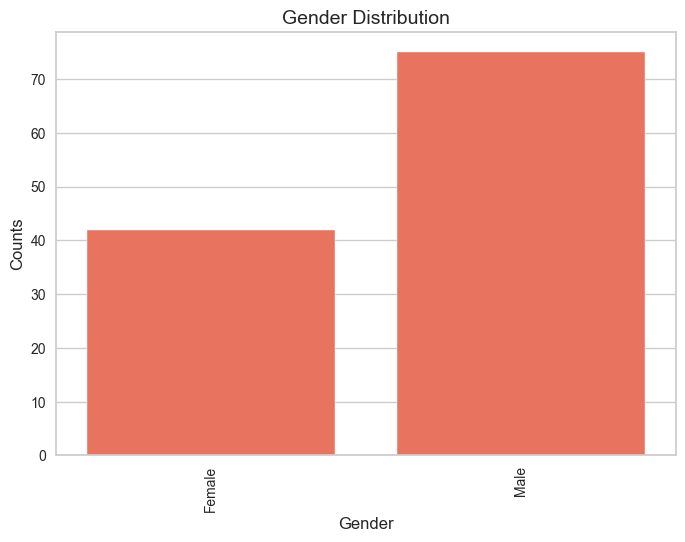

In [269]:
sns.set_style('whitegrid')

# Creació del gràfic de countplot per Gender
sns.countplot(x='Gender', data=df, color='#FF6347')

# Afegir el títol i les etiquetes
plt.title('Gender Distribution', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xticks([0, 1], ['Female', 'Male'], rotation=90)

plt.show()

Observem que hi ha molts més **personatges** que són **homes**.

A continuació, mirarem com és la **distrubució** per **Job** del nostre Dataset.

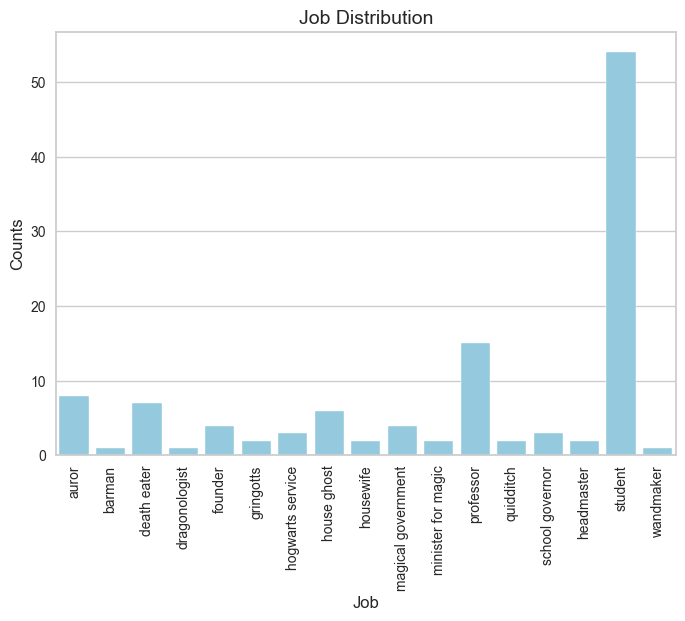

In [270]:
sns.set_style('whitegrid')

# Creació del gràfic de countplot per Job
sns.countplot(x='Job', data=df, color='#87CEEB')

# Afegir el títol i les etiquetes
plt.title('Job Distribution', fontsize=14)
plt.xlabel('Job', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], ['auror', 'barman', 'death eater', 'dragonologist', 'founder', 'gringotts', 'hogwarts service', 'house ghost', 'housewife', 'magical government', 'minister for magic', 'professor', 'quidditch', 'school governor', 'headmaster', 'student', 'wandmaker'], rotation=90)

plt.show()

Observem que la **feina** més **freqüent** és la d'**estudiant**, això ens quadra ja que la història es centra en **Hogwarts School**.

A continuació, mirarem com és la **distrubució** per **House** del nostre Dataset.

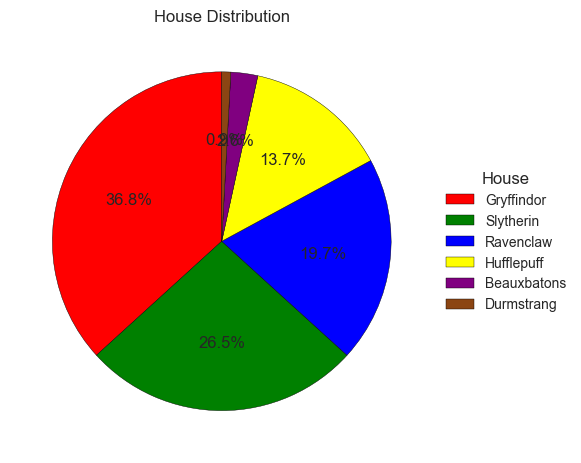

In [271]:
# Comptem quants personatges hi ha a cada casa
house_counts = df['House'].value_counts()

colors = ['#FF0000', '#008000', '#0000FF', '#FFFF00', '#800080', '#8B4513']

# Crear el gràfic de pastís
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(house_counts, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})

# Afegim la llegenda
ax.legend(wedges, ['Gryffindor', 'Slytherin', 'Ravenclaw', 'Hufflepuff', 'Beauxbatons', 'Durmstrang'], 
          title="House", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('House Distribution')

plt.show()

Observem que la majoria de **personatges** pertanyen a la **casa** de **Gryffindor**, seguida per la de **Slytherin**.

A continuació, mirarem com és la **distrubució** per **Species** del nostre Dataset.

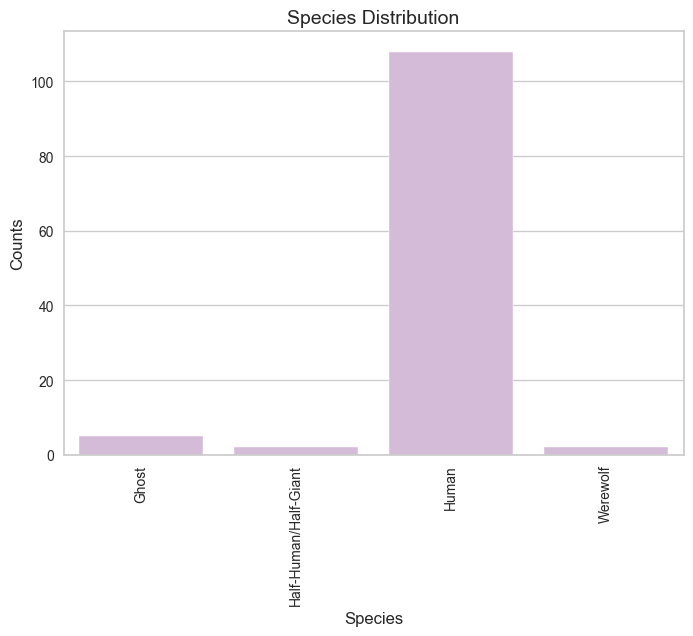

In [272]:
sns.set_style('whitegrid')

# Creació del gràfic de countplot per Species
sns.countplot(x='Species', data=df, color='#D8B7DD')

# Afegir el títol i les etiquetes
plt.title('Species Distribution', fontsize=14)
plt.xlabel('Species', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xticks([0, 1, 2, 3,], ['Ghost', 'Half-Human/Half-Giant', 'Human', 'Werewolf'], rotation=90)

plt.show()

Veiem que la majoria dels **personatges** pertanyen a la espècie de **Human**.

A continuació, mirarem com és la **distrubució** per **Blood status** del nostre Dataset.

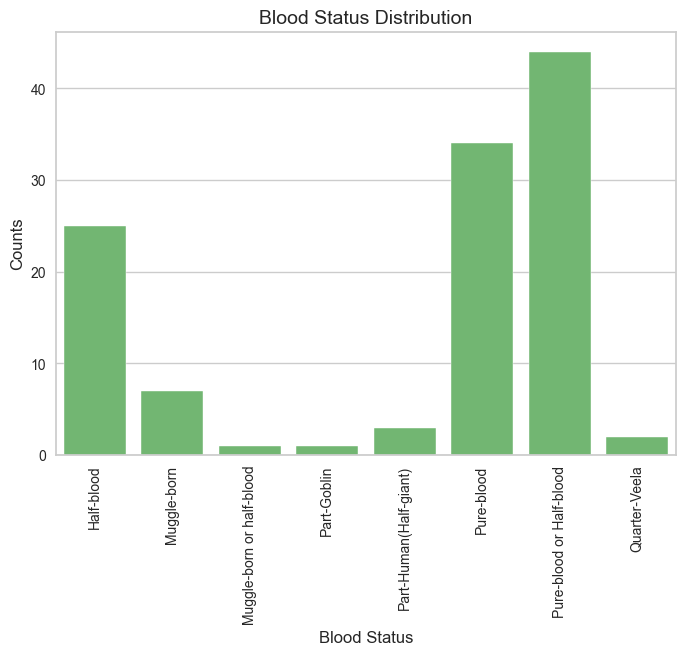

In [273]:
sns.set_style('whitegrid')

# Creació del gràfic de countplot per Blood status
sns.countplot(x='Blood status', data=df, color='#66C266')

# Afegir el títol i les etiquetes
plt.title('Blood Status Distribution', fontsize=14)
plt.xlabel('Blood Status', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['Half-blood', 'Muggle-born', 'Muggle-born or half-blood', 'Part-Goblin', 'Part-Human(Half-giant)', 'Pure-blood', 'Pure-blood or Half-blood', 'Quarter-Veela'], rotation=90)

plt.show()

Veiem que la majoria dels **personatges** tenen com a **Blood status**, **Pure-blood or Half-blood**.

A més a més, mirarem com és la **distrubució** de **Loyalty**, agafant 4 valors diferents d'aquesta característica, i ho compararem amb la característica **House**. D'aquesta manera, podrem determinar quina des les cases és més lleial a una certa persona.

C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\3437431393.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=90)
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\3437431393.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=90)
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\3437431393.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
C:\Users\nerea\AppData\Local\Temp\ipykernel_13124\3437431393.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  

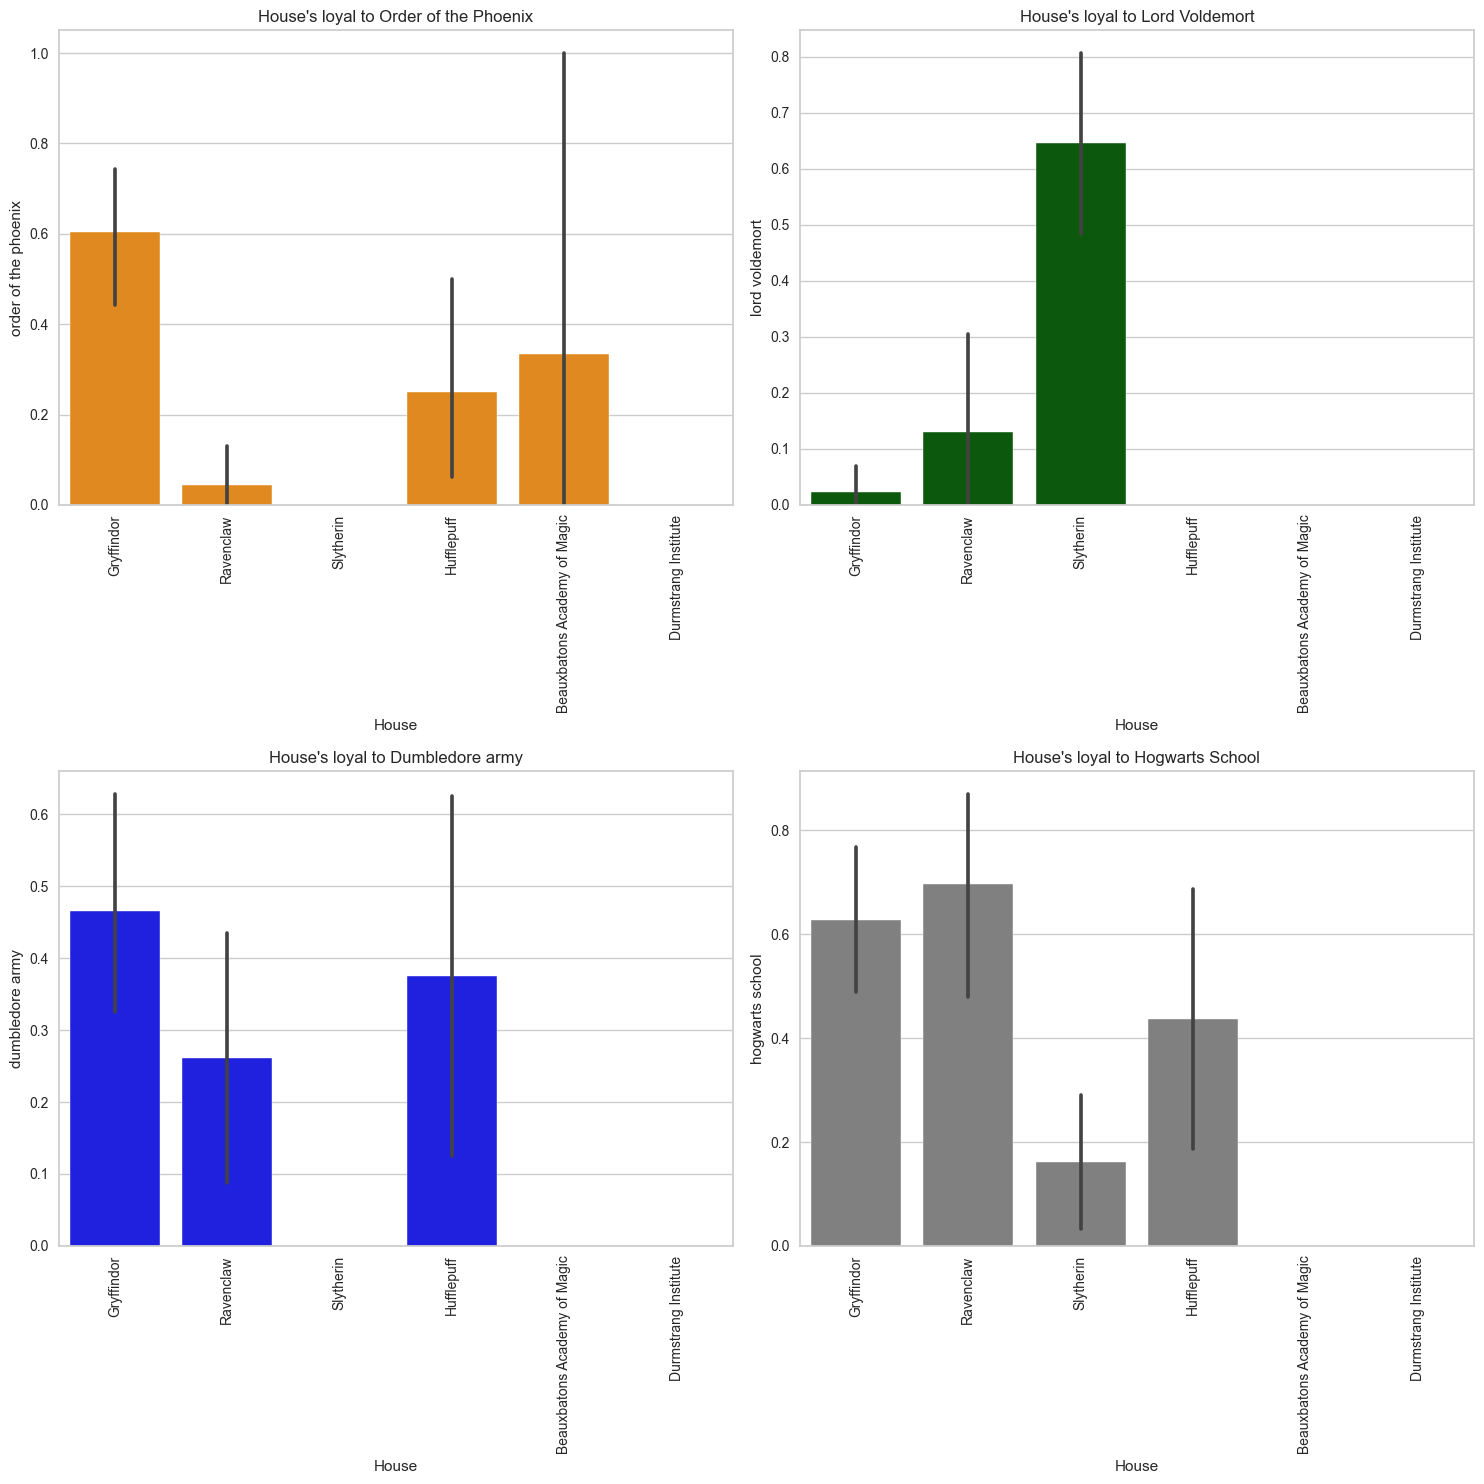

In [274]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

sns.barplot(x="House", y="order of the phoenix", data=df, ax=axes[0, 0], color='#FF8C00')
axes[0, 0].set_title("House's loyal to Order of the Phoenix")
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=90)

sns.barplot(x="House", y="lord voldemort", data=df, ax=axes[0, 1], color='#006400')
axes[0, 1].set_title("House's loyal to Lord Voldemort")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=90)

sns.barplot(x="House", y="dumbledore army", data=df, ax=axes[1, 0], color='#0000FF')
axes[1, 0].set_title("House's loyal to Dumbledore army")
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)

sns.barplot(x="House", y="hogwarts school", data=df, ax=axes[1, 1], color='#808080')
axes[1, 1].set_title("House's loyal to Hogwarts School")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

Respecte a les **cases** que són lleials a **Order of the Phoenix**, veiem que la casa Gryffindor és la més lleial.

Si mirem la gràfica de les **cases** més lleials a **Lord Voldemort**, obervem que és la casa Slytherin. Te bastant sentit, ja que la majoria de personatges d'aquesta casa, sabem que estàn a favor de **Lord Voldemort**.

També podem veure que totes les **cases** excepte la de **Slytherin**, són lleials a **Dumbledore army**, cosa que ens quadra amb la gràfica anterior. Ja que els personatges que són lleials a **Dumbledore army**, no són lleials a **Lord Voldemort**.

Per últim, observem també que totes les cases són lleials a **Hogwarts School**. Algunes ho són més, com **Ravenclaw** i **Gryffindor**, i n'hi ha algunes que no tant, com **Slytherin**.

Per últim, mirarem la **correlació** entre totes les **característiques**:

Però primer, haurem de fer **encoding** de la caracterísitca **House**.

In [275]:
numeric_features = df.select_dtypes(np.number).keys()
non_numeric = ['House']
le = LabelEncoder()
df.loc[:,non_numeric] = df.loc[:,non_numeric].apply(le.fit_transform)
df.head()

,Id,Gender,Job,House,Species,Blood status,Hair colour,Eye colour,parsel,wizard chess,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,other schools,gringotts
116,1,1,15,2,2,0,2,4,1,0,...,1,1,1,0,1,0,0,0,0,0
101,2,1,15,2,2,5,15,1,0,1,...,0,1,1,0,1,0,0,0,0,0
102,3,0,15,2,2,1,5,5,0,0,...,0,1,1,0,1,0,0,0,0,0
103,4,1,14,2,2,0,20,1,0,0,...,0,1,1,0,1,0,0,0,0,0
104,5,1,11,2,1,4,2,0,0,0,...,1,0,1,0,1,0,0,0,0,0


Ara ja podem fer el **gràfic** de **correlacions**.

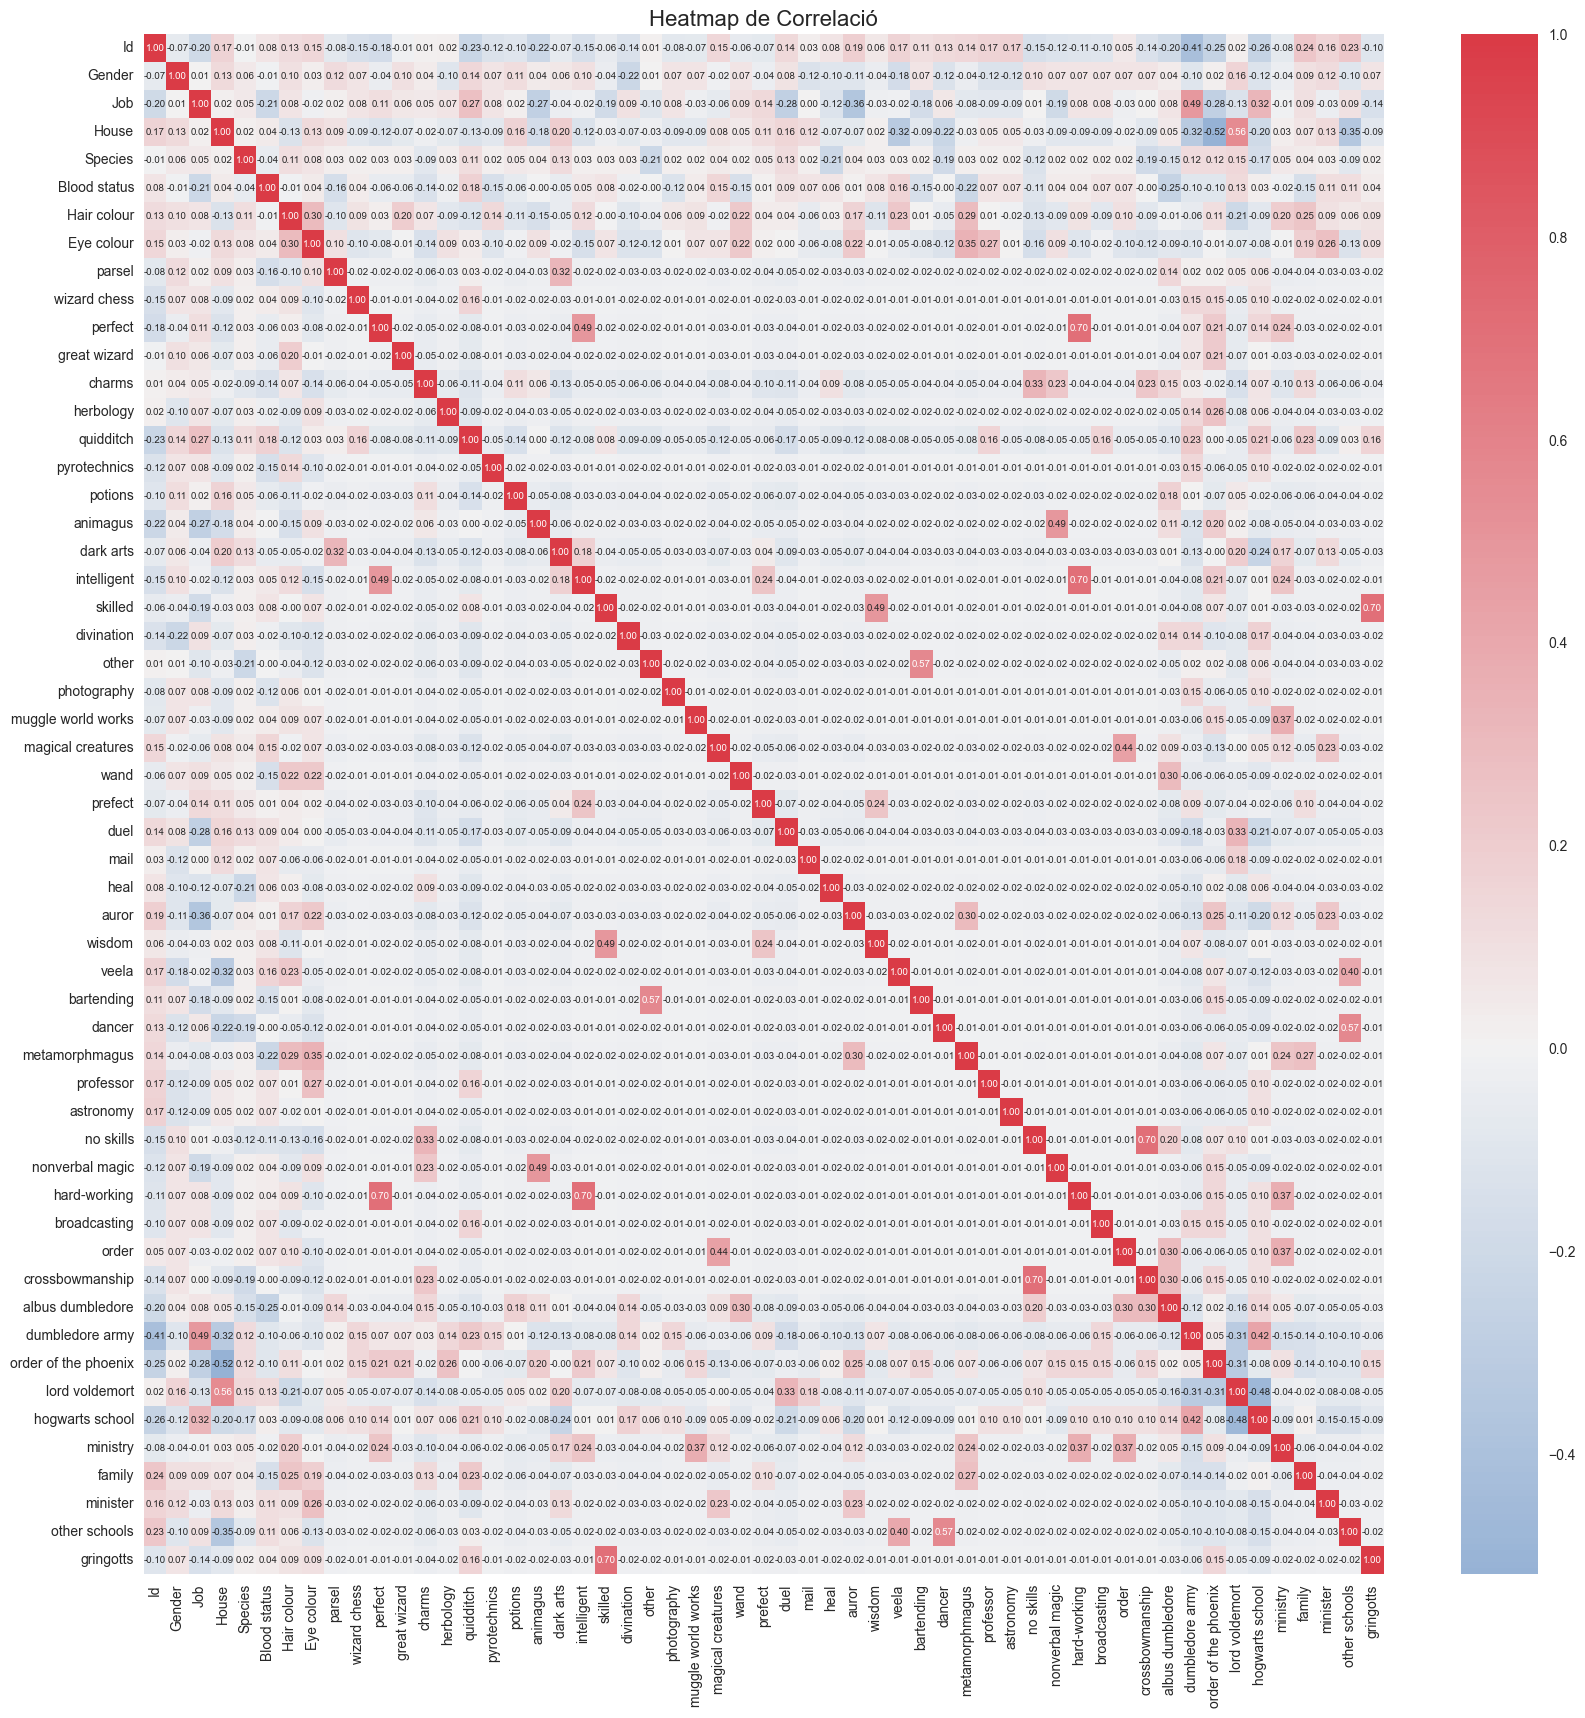

In [276]:
sns.set_style('whitegrid')

#plt.figure(figsize=(12, 9))
plt.figure(figsize=(20, 20))

palette = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(df.corr(), cmap=palette, annot=True, fmt=".2f", center=0, annot_kws={"size": 7})

plt.title('Heatmap de Correlació', fontsize=16)

plt.show()

Observem que les **característiques** més **correlacionades** amb la variable target **House** són:

* **Lord Voldemort** (0.56)
* **Gender** (0.13)
* **Eye colour** (0.13)
* **Ministry** (0.10)

# 3.NORMALITZACIÓ

**Normalitzem** les dades. En concret, els atributs **Job**, **Hair colour**, **Eye colour** i **Skills**.

In [277]:
numerical_columns=['Species', 'Blood status', 'Hair colour', 'Eye colour'] #'Job' 'Skills'
sc = StandardScaler()
train_norm=sc.fit_transform(df.loc[:,numerical_columns])

df[numerical_columns]=train_norm
df.head()

,Id,Gender,Job,House,Species,Blood status,Hair colour,Eye colour,parsel,wizard chess,...,albus dumbledore,dumbledore army,order of the phoenix,lord voldemort,hogwarts school,ministry,family,minister,other schools,gringotts
116,1,1,15,2,0.192166,-1.654197,-0.925617,-0.400810,1,0,...,1,1,1,0,1,0,0,0,0,0
101,2,1,15,2,0.192166,0.396026,0.924400,-1.104233,0,1,...,0,1,1,0,1,0,0,0,0,0
102,3,0,15,2,0.192166,-1.244152,-0.498690,-0.166336,0,0,...,0,1,1,0,1,0,0,0,0,0
103,4,1,14,2,0.192166,-1.654197,1.635946,-1.104233,0,0,...,0,1,1,0,1,0,0,0,0,0
104,5,1,11,2,-2.056172,-0.014019,-0.925617,-1.338707,0,0,...,1,0,1,0,1,0,0,0,0,0


# 4. SELECCIÓ DE FEATURES

In [278]:
from sklearn.linear_model import LogisticRegression
from itertools import combinations

# Inversió del procés de encoding, convertim els números a les paraules originals
df['House'] = le.inverse_transform(df['House'].astype(int))

target = 'House'
attributes = [k for k in df.keys() if k!= target]
X = df[attributes]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=42)

# Inicialitzem una llista per guardar les combinacions i els seus f1_scores
results = []
"""
# Provem totes les combinacions possibles d'atributs
for L in range(1, len(X_train.columns) + 1):
    for subset in combinations(X_train.columns, L):
        # Creem un model utilitzant la combinació actual d'atributs
        model = LogisticRegression(max_iter=250)
        model.fit(X_train[list(subset)], y_train)
        
        # Predicció sobre el conjunt de proves
        y_pred = model.predict(X_test[list(subset)])
        
        # Càlcul de l'error (f1_score)
        score = f1_score(y_test, y_pred, average='weighted')
        
        # Guardem els resultats
        results.append({'Combination': subset, 'F1 Score': score})

# Trobaem la millor combinació
best_result = max(results, key=lambda x: x['F1 Score'])

# Mostrem totes les combinacions amb els seus f1_scores corresponents
print("Combinacions i els seus f1_scores:")
for result in results:
    print(f"Combinació: {result['Combination']}, F1 Score: {result['F1 Score']:.4f}")

# Mostrem la millor combinació
print(f"\nLa millor combinació d'atributs és: {best_result['Combination']}")
print(f"Amb un f1_score de: {best_result['F1 Score']:.4f}")
"""

'\n# Provem totes les combinacions possibles d\'atributs\nfor L in range(1, len(X_train.columns) + 1):\n    for subset in combinations(X_train.columns, L):\n        # Creem un model utilitzant la combinació actual d\'atributs\n        model = LogisticRegression(max_iter=250)\n        model.fit(X_train[list(subset)], y_train)\n        \n        # Predicció sobre el conjunt de proves\n        y_pred = model.predict(X_test[list(subset)])\n        \n        # Càlcul de l\'error (f1_score)\n        score = f1_score(y_test, y_pred, average=\'weighted\')\n        \n        # Guardem els resultats\n        results.append({\'Combination\': subset, \'F1 Score\': score})\n\n# Trobaem la millor combinació\nbest_result = max(results, key=lambda x: x[\'F1 Score\'])\n\n# Mostrem totes les combinacions amb els seus f1_scores corresponents\nprint("Combinacions i els seus f1_scores:")\nfor result in results:\n    print(f"Combinació: {result[\'Combination\']}, F1 Score: {result[\'F1 Score\']:.4f}")\n\n# 

# 5. METRIC SELECTION

In [279]:
lr = OneVsOneClassifier(LogisticRegression(max_iter=300, fit_intercept = True))
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
classification = classification_report(y_test, y_pred)

print("Provem les diferents mètriques: \n")

precision_micro = precision_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f'Precisió (Micro): {precision_micro}')
print(f'Precisió (Macro): {precision_macro}')
print(f'Precisió (weighted): {precision_weighted}')
print(f'Recall (Micro): {recall_micro}')
print(f'Recall (Macro): {recall_macro}')
print(f'Recall (weighted): {recall_weighted}')
print(f'F1 Score (Micro): {f1_micro}')
print(f'F1 Score (Macro): {f1_macro}')
print(f'F1 Score (weighted): {f1_weighted}')

print(classification)

Provem les diferents mètriques: 

Precisió (Micro): 0.5666666666666667
Precisió (Macro): 0.36640211640211645
Precisió (weighted): 0.5682539682539682
Recall (Micro): 0.5666666666666667
Recall (Macro): 0.3531746031746032
Recall (weighted): 0.5666666666666667
F1 Score (Micro): 0.5666666666666667
F1 Score (Macro): 0.34078144078144074
F1 Score (weighted): 0.5416849816849817
                              precision    recall  f1-score   support

Beauxbatons Academy of Magic       0.00      0.00      0.00         1
        Durmstrang Institute       0.00      0.00      0.00         0
                  Gryffindor       0.64      0.75      0.69        12
                  Hufflepuff       0.33      0.25      0.29         4
                   Ravenclaw       0.67      0.29      0.40         7
                   Slytherin       0.56      0.83      0.67         6

                    accuracy                           0.57        30
                   macro avg       0.37      0.35      0.34       

c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

En aquest cas, hem utilitzat l'estratègia **OneVsOneClassifier**.

A més, hem calculat la **precisió**, el **recall** i l'**f1_score** utilitzat els promigs **Micro**, **Macro** i **Weighted**.

Els resultats obtinguts han estat millors fent servir el promig **Weighted** amb la **precisió** i el **f1_score**.

In [280]:
lr = OneVsRestClassifier(LogisticRegression(max_iter=300, fit_intercept = True))
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
classification = classification_report(y_test, y_pred)

print("Provem les diferents mètriques: \n")

precision_micro = precision_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_micro = recall_score(y_test, y_pred, average='micro')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f'Precisió (Micro): {precision_micro}')
print(f'Precisió (Macro): {precision_macro}')
print(f'Precisió (weighted): {precision_weighted}')
print(f'Recall (Micro): {recall_micro}')
print(f'Recall (Macro): {recall_macro}')
print(f'Recall (weighted): {recall_weighted}')
print(f'F1 Score (Micro): {f1_micro}')
print(f'F1 Score (Macro): {f1_macro}')
print(f'F1 Score (weighted): {f1_weighted}')

print(classification)

Provem les diferents mètriques: 

Precisió (Micro): 0.7666666666666667
Precisió (Macro): 0.8016666666666667
Precisió (weighted): 0.7783333333333334
Recall (Micro): 0.7666666666666667
Recall (Macro): 0.7976190476190477
Recall (weighted): 0.7666666666666667
F1 Score (Micro): 0.7666666666666667
F1 Score (Macro): 0.7928571428571429
F1 Score (weighted): 0.7650793650793649
                              precision    recall  f1-score   support

Beauxbatons Academy of Magic       1.00      1.00      1.00         1
                  Gryffindor       0.83      0.83      0.83        12
                  Hufflepuff       0.75      0.75      0.75         4
                   Ravenclaw       0.80      0.57      0.67         7
                   Slytherin       0.62      0.83      0.71         6

                    accuracy                           0.77        30
                   macro avg       0.80      0.80      0.79        30
                weighted avg       0.78      0.77      0.77        3

En aquest cas, hem utilitzat l'estratègia **OneVsRestClassifier**.

A més, hem calculat la **precisió**, el **recall** i l'**f1_score** utilitzat els promigs **Micro**, **Macro** i **Weighted**.

Els resultats obtinguts han estat millors fent servir el promig **Weighted** seguit de **Micro**, amb la **precisió** i el **f1_score**.

Comparació

**Confusion Matrix**

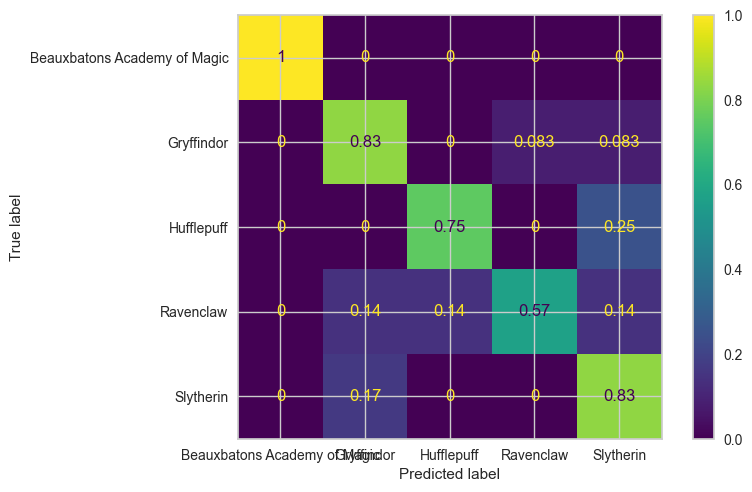

In [281]:
f1 = f1_score(y_test, y_pred, average='weighted')
confusion = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')

# 6. MODEL SELECTION

Trobem el millor model amb els hiperparametres per defecte, utilitzant **validació creuada**.

En el nostre cas és millor utilitzar la StratifiedKFold, ja que garanteix que cada "fold" tingui una distribució similar de la classe objectiu (la proporció de les cases es manté constant).

In [282]:
def f1_score_comparison(models, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.barh(models, f1_scores, color='skyblue')

    plt.xlabel('F1-Score')
    plt.title('Comparació de F1-Score entre Models')

    for i, v in enumerate(f1_scores):
        plt.text(v + 0.01, i, f"{v:.2f}", va='center')

    plt.tight_layout()
    plt.show()


c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the numb

Logistic Regression: F1 score mitjana en CV = 0.4752
SVM: F1 score mitjana en CV = 0.4104
Random Forest: F1 score mitjana en CV = 0.6360
KNN: F1 score mitjana en CV = 0.6673


c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Gradient Boosting Classifier: F1 score mitjana en CV = 0.6969
Decision Tree Classifier: F1 score mitjana en CV = 0.6709


c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


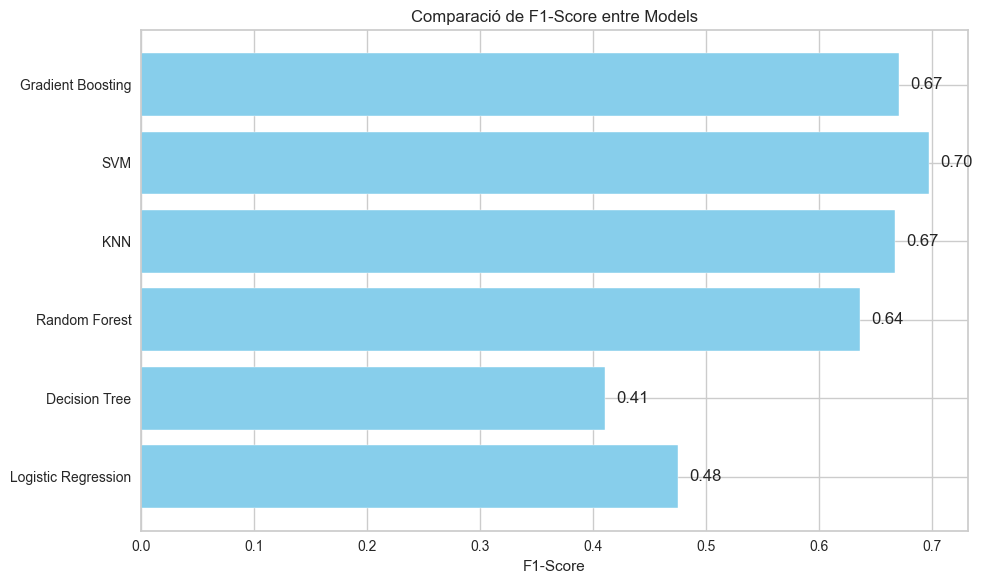

In [283]:
models=['Logistic Regression', "Decision Tree", 'Random Forest', 'KNN', 'SVM', 'Gradient Boosting']
f1_scores=[]
models2 = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier()
}

f1_scores=[]
for name, model in models2.items():
    scores = cross_val_score(model, X_train, y_train, cv = StratifiedKFold(n_splits = 5), scoring = 'f1_weighted')
    print(f'{name}: F1 score mitjana en CV = {scores.mean():.4f}')
    f1_scores.append(scores.mean())

f1_score_comparison(models, f1_scores)


# 7. HYPERPARAMETERS SEARCH

Trobem els millors hiperparametres per cada model utilitzant VC i Grid search. 

In [284]:
"""
param_grid = {
    'C': [0.1, 1, 10, 50, 100, 1000],  # Regularització
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],  # Tipus de kernel
    'gamma': [1,0.1,0.01,0.001,0.0001],  # Paràmetre gamma per a rbf/poly
}

svc = SVC()
start_time = time.time()
grid_search_svc = GridSearchCV(svc, param_grid, cv=StratifiedKFold(n_splits = 10, random_state=1, shuffle=True), scoring='f1_weighted')
grid_search_svc.fit(X_train, y_train)
end_time = time.time()
total_time = end_time - start_time
print(f"Temps d'execució: {total_time} segons")
print(f'Millors hiperparàmetres: {grid_search_svc.best_params_}')
print(f'Millor score: {grid_search_svc.best_score_:.4f}')
"""

'\nparam_grid = {\n    \'C\': [0.1, 1, 10, 50, 100, 1000],  # Regularització\n    \'kernel\': [\'rbf\', \'linear\', \'poly\', \'sigmoid\'],  # Tipus de kernel\n    \'gamma\': [1,0.1,0.01,0.001,0.0001],  # Paràmetre gamma per a rbf/poly\n}\n\nsvc = SVC()\nstart_time = time.time()\ngrid_search_svc = GridSearchCV(svc, param_grid, cv=StratifiedKFold(n_splits = 10, random_state=1, shuffle=True), scoring=\'f1_weighted\')\ngrid_search_svc.fit(X_train, y_train)\nend_time = time.time()\ntotal_time = end_time - start_time\nprint(f"Temps d\'execució: {total_time} segons")\nprint(f\'Millors hiperparàmetres: {grid_search_svc.best_params_}\')\nprint(f\'Millor score: {grid_search_svc.best_score_:.4f}\')\n'

# 8. ANÀLISI FINAL

A continuació, farem la predicció de **House** per a cada **personatge**.

En primer lloc, separem el **target** i les **característiques**.

Calculem l'**f1_score** de **test**.

In [285]:
scores = cross_val_score(SVC(C= 1, gamma=0.01, kernel='rbf'), X_train, y_train, cv = StratifiedKFold(n_splits = 10), scoring = 'f1_weighted')
print(f'SVM : F1 score mitjana en CV = {scores.mean():.4f}')

SVM : F1 score mitjana en CV = 0.6879


c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Observem que tant **f1_score** ens dona uns valors bastant alts. Això significa que el nostre **model** **classifica** bé les **cases** de cada **personatge** al voltant del **71%**.

**RCC i PR curve**

c:\Users\nerea\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


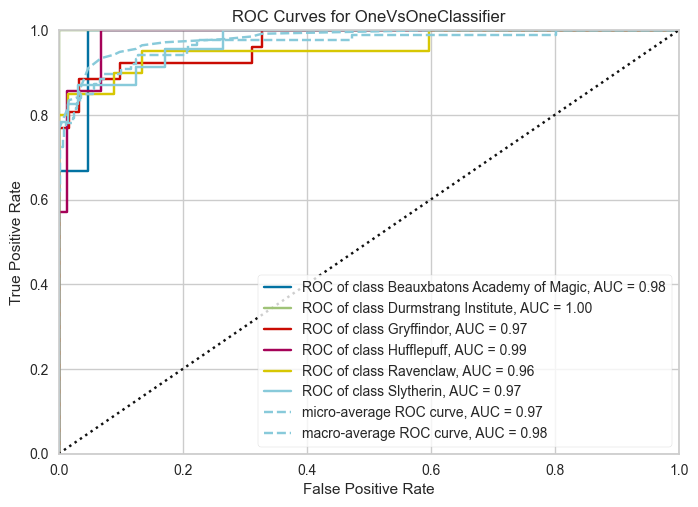

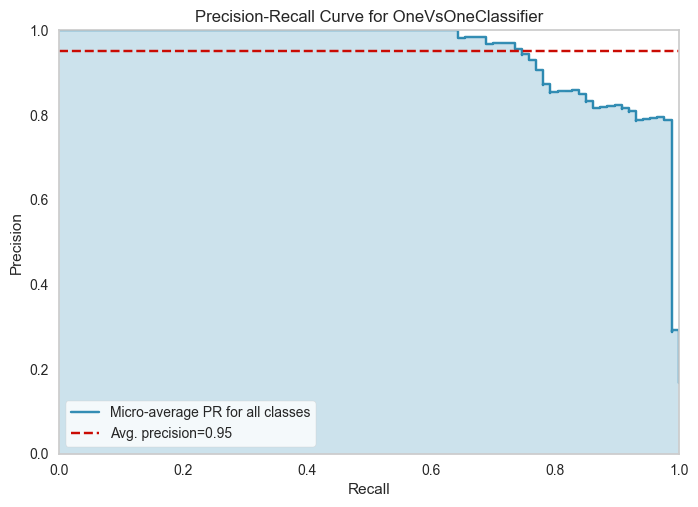

<Axes: title={'center': 'Precision-Recall Curve for OneVsOneClassifier'}, xlabel='Recall', ylabel='Precision'>

In [286]:
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

df['House'] = le.fit_transform(df['House'])

target = 'House'
attributes = [k for k in df.keys() if k!= target]
X = df[attributes]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=2)

model = OneVsOneClassifier(SVC(C= 1, gamma=0.01, kernel='rbf'))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Corba ROC
roc = ROCAUC(model, classes=['Beauxbatons Academy of Magic', 'Durmstrang Institute', 'Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin'])
roc.fit(X_train, y_train)
roc.score(X_train, y_train)
roc.show()

# Corba PR
pr = PrecisionRecallCurve(model, classes=['Beauxbatons Academy of Magic', 'Durmstrang Institute', 'Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin'])
pr.fit(X_train, y_train)
pr.score(X_train, y_train)
pr.show()
